# Tracing

In [78]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 14] 

In [79]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])
    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace.apply(pd.to_numeric, errors='ignore')

In [160]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    data = trace[(trace['event'] == from_event) | (trace['event'] == to_event)]
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    result = np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64)
    if len(result) < 1000:
        print("There are " + str(len(result)) + " events from: '" + from_event + "', to: '" + to_event + ";")
    return result

In [161]:
def sync_skew(trace):
    for location in trace['location'].unique():
        d = delay_between(trace, 'rear-in', 'bench-receive', from_location=location)
        if d.size > 0:
            min = d.min()
            trace.loc[trace['location'] == location, 'ts'] += min
    return trace

In [178]:
p = sync_skew(parse_trace("../FlameStream/benchmark/ansible/results/b1ca5604/4/100/flamestream/traces"))
start = p['ts'].min() + 200 * (100 * 1e6)
p = p[p['ts'] > start]
p.shape

There are 0 events from: 'rear-in', to: 'bench-receive;


(65386, 3)

In [179]:
p['event'].unique()

array(['inject-out', 'flatmap-receive', 'rear-in', 'flatmap-send',
       'inject-in', 'barrier-receive', 'wrong-ordering-filter-receive',
       'barrier-send', 'grouping-receive', 'bench-receive', 'bench-send',
       'front-receive-send', 'accept-out', 'accept-in'], dtype=object)

# Events

| event | id | comment |
|:------|:---|:--------|
| bench-send | article id | Begin of the pipeline |
| front-receive-send | article id | In the front |
| accept-in | article id | GraphManager::accept |
| accept-out | article id | GraphManager::accept |
| flatmap-receive | article id | After shuffle in the flatmap |
| inject-in | xor | GraphManager::inject |
| inject-out | xor | GraphManager::inject |
| flatmap-send | xor | RouterJoba::accept |
| grouping-receive | xor | GroupingJoba |
| barrier-receive | xor | SinkJoba |
| barrier-send | xor | SinkJoba |

There are 795 events from: 'bench-send', to: 'front-receive-send;
There are 792 events from: 'accept-in', to: 'accept-out;
There are 795 events from: 'front-receive-send', to: 'flatmap-receive;
There are 880 events from: 'inject-in', to: 'inject-out;
There are 785 events from: 'front-receive-send', to: 'accept-in;


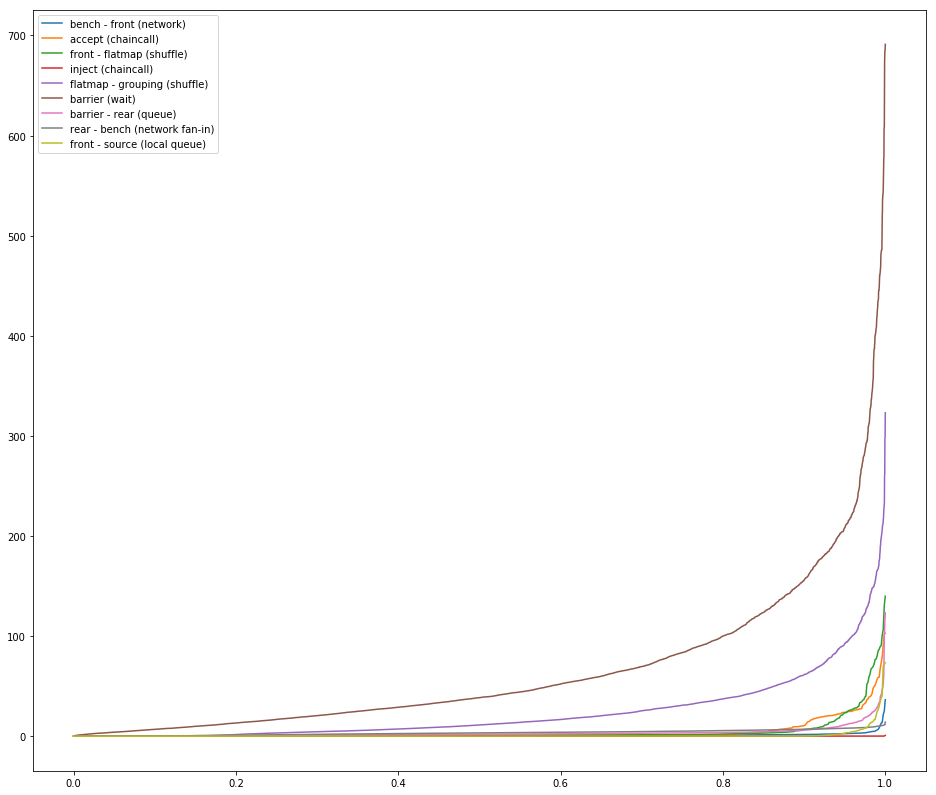

In [180]:
def stage_plots(trace) :
    bench_front = delay_between(trace, 'bench-send', 'front-receive-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), label="bench - front (network)")
    
    accept = delay_between(trace, 'accept-in', 'accept-out') / 1e6
    plt.plot(np.linspace(0, 1, np.size(accept)), np.sort(accept), label="accept (chaincall)")

    to_source = delay_between(trace, 'front-receive-send', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(to_source)), np.sort(to_source), label="front - flatmap (shuffle)")
    
    inject = delay_between(trace, 'inject-in', 'inject-out') / 1e6
    plt.plot(np.linspace(0, 1, np.size(inject)), np.sort(inject), label="inject (chaincall)")
    
    part = delay_between(trace, 'flatmap-send', 'grouping-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(part)), np.sort(part), label="flatmap - grouping (shuffle)")

    barrier = delay_between(trace, 'barrier-receive', 'barrier-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(barrier)), np.sort(barrier), label="barrier (wait)")

    to_rear = delay_between(trace, 'barrier-send', 'rear-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(to_rear)), np.sort(to_rear), label="barrier - rear (queue)")

    rear_bench = delay_between(trace, 'rear-in', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(rear_bench)), np.sort(rear_bench), label="rear - bench (network fan-in)")
    
    front_source = delay_between(trace, 'front-receive-send', 'accept-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(front_source)), np.sort(front_source), label="front - source (local queue)")

    plt.legend(loc='upper left')
    plt.show()

stage_plots(p)